In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from scipy.misc import imread, imshow
from tensorflow.examples.tutorials.mnist import input_data

from caffe_classes import class_names
%matplotlib inline

In [2]:
alexnet = '/Users/avilay.parekh/projects/personal/deeplearning/sdc-class/CarND-Alexnet-Feature-Extraction/bvlc-alexnet.npy'
data = np.load(alexnet, encoding='latin1').item()

In [3]:
data.keys()

dict_keys(['fc6', 'fc7', 'fc8', 'conv3', 'conv2', 'conv1', 'conv5', 'conv4'])

## AlexNet

Input --> conv1 --> norm/maxpool1 --> conv2 (split) --> norm/maxpool2 --> conv3 --> conv4 (split) --> conv5 (split) --> maxpool --> fc6 --> fc7 --> fc8(output)

In [4]:
# Input layer
X = tf.placeholder(tf.float32, (None, 227, 227, 3))

In [5]:
# Layer 1: conv1
# kernel: 11 x 11
# filters: 96
strides = (1, 4, 4, 1)
W1 = tf.Variable(data['conv1'][0])  # 11 x 11 x 3 x 96
b1 = tf.Variable(data['conv1'][1])  # 96
conv1_Z = tf.nn.bias_add(tf.nn.conv2d(X, W1, strides, padding='SAME'), b1)
conv1 = tf.nn.relu(conv1_Z)  # 57 x 57 x 96

print('conv1: ', conv1.get_shape())
print(f'\tW1: {W1.get_shape()}, b1: {b1.get_shape()}')

conv1:  (?, 57, 57, 96)
	W1: (11, 11, 3, 96), b1: (96,)


In [6]:
# Normalize
r = 2
α = 2e-05
β = 0.75
bias = 1.0
lrn1 = tf.nn.local_response_normalization(conv1, depth_radius=r, alpha=α, beta=β, bias=bias)

# Layer 2: maxpool1
kernel = (1, 3, 3, 1)
strides = (1, 2, 2, 1)
maxpool1 = tf.nn.max_pool(lrn1, ksize=kernel, strides=strides, padding='VALID')  # 28 x 28 x 96
print('maxpool1: ', maxpool1.get_shape())

maxpool1:  (?, 28, 28, 96)


In [7]:
# Layer 3: conv2 - split convolution
# kernel: 5 x 5
# filters: 256
strides = (1, 1, 1, 1)

weights = np.split(data['conv2'][0], 2, axis=3)
b2 = tf.Variable(data['conv2'][1])  # 256
W2_0 = tf.Variable(weights[0])  # 5 x 5 x 48 x 128
W2_1 = tf.Variable(weights[1])  # 5 x 5 x 48 x 128

maxpool1_0, maxpool1_1 = tf.split(maxpool1, 2, axis=3)  # 28 x 28 x 48

conv2_Z0 = tf.nn.conv2d(maxpool1_0, W2_0, strides, padding='SAME')  # 28 x 28 x 128
conv2_Z1 = tf.nn.conv2d(maxpool1_1, W2_1, strides, padding='SAME')  # 28 x 28 x 128

conv2_Z = tf.nn.bias_add(tf.concat([conv2_Z0, conv2_Z1], axis=3), b2)  
conv2 = tf.nn.relu(conv2_Z)  # 28 x 28 x 256

print('conv2: ', conv2.get_shape())
print(f'\tW2_0: {W2_0.get_shape()}, W2_1: {W2_1.get_shape()}, b2: {b2.get_shape()}')
print(f'\tmaxpool1_0: {maxpool1_0.get_shape()}, maxpool1_1: {maxpool1_1.get_shape()}')
print(f'\tconv2_Z0: {conv2_Z0.get_shape()}, conv2_Z1: {conv2_Z1.get_shape()}')

conv2:  (?, 28, 28, 256)
	W2_0: (5, 5, 48, 128), W2_1: (5, 5, 48, 128), b2: (256,)
	maxpool1_0: (?, 28, 28, 48), maxpool1_1: (?, 28, 28, 48)
	conv2_Z0: (?, 28, 28, 128), conv2_Z1: (?, 28, 28, 128)


In [8]:
# Normalize
r = 2
α = 2e-05
β = 0.75
bias = 1.0
lrn2 = tf.nn.local_response_normalization(conv2, depth_radius=r, alpha=α, beta=β, bias=bias)

# Layer 4: maxpool2
kernel = (1, 3, 3, 1)
strides = (1, 2, 2, 1)
maxpool2 = tf.nn.max_pool(lrn2, ksize=kernel, strides=strides, padding='VALID')  # 13 x 13 x 256
print('maxpool2: ', maxpool2.get_shape())

maxpool2:  (?, 13, 13, 256)


In [9]:
# Layer 5: conv3
# kernel: 3 x 3
# filters: 384
strides = (1, 1, 1, 1)
W3 = tf.Variable(data['conv3'][0])  # 3 x 3 x 256 x 384
b3 = tf.Variable(data['conv3'][1])  # 384
conv3_Z = tf.nn.bias_add(tf.nn.conv2d(maxpool2, W3, strides=strides, padding='SAME'), b3)
conv3 = tf.nn.relu(conv3_Z)  # 13 x 13 x 384

print('conv3: ', conv3.get_shape())
print(f'\tW3: {W3.get_shape()}, b3: {b3.get_shape()}')

conv3:  (?, 13, 13, 384)
	W3: (3, 3, 256, 384), b3: (384,)


In [10]:
# Layer 6: conv4 - split convolution
# kernel: 3 x 3
# filters: 384
strides = (1, 1, 1, 1)

weights = np.split(data['conv4'][0], 2, axis=3)
W4_0 = tf.Variable(weights[0])  # 3 x 3 x 192 x 192
W4_1 = tf.Variable(weights[1])  # 3 x 3 x 192 x 192
b4 = tf.Variable(data['conv4'][1])  # 384

conv3_0, conv3_1 = tf.split(conv3, 2, axis=3)  # 13 x 13 x 192

conv4_Z0 = tf.nn.conv2d(conv3_0, W4_0, strides=strides, padding='SAME')  # 13 x 13 x 192
conv4_Z1 = tf.nn.conv2d(conv3_1, W4_1, strides=strides, padding='SAME')  # 13 x 13 x 192

conv4_Z = tf.nn.bias_add(tf.concat([conv4_Z0, conv4_Z1], axis=3), b4)
conv4 = tf.nn.relu(conv4_Z)  # 13 x 13 384

print('conv4: ', conv4.get_shape())
print(f'\tW4_0: {W4_0.get_shape()}, W4_1: {W4_1.get_shape()}, b4: {b4.get_shape()}')
print(f'\tconv3_0: {conv3_0.get_shape()}, conv3_1: {conv3_1.get_shape()}')
print(f'\tconv4_Z0: {conv4_Z0.get_shape()}, conv4_Z1: {conv4_Z1.get_shape()}')

conv4:  (?, 13, 13, 384)
	W4_0: (3, 3, 192, 192), W4_1: (3, 3, 192, 192), b4: (384,)
	conv3_0: (?, 13, 13, 192), conv3_1: (?, 13, 13, 192)
	conv4_Z0: (?, 13, 13, 192), conv4_Z1: (?, 13, 13, 192)


In [11]:
# Layer 7: conv5 - split convolution
# kernel: 3 x 3
# filters: 256
strides = (1, 1, 1, 1)

weights = np.split(data['conv5'][0], 2, axis=3)
W5_0 = tf.Variable(weights[0])  # 3 x 3 x 192 x 128
W5_1 = tf.Variable(weights[1])  # 3 x 3 x 192 x 128
b5 = tf.Variable(data['conv5'][1])  # 256

conv4_0, conv4_1 = tf.split(conv4, 2, axis=3)  # 13 x 13 x 192

conv5_Z0 = tf.nn.conv2d(conv4_0, W5_0, strides=strides, padding='SAME')  # 13 x 13 x 128
conv5_Z1 = tf.nn.conv2d(conv4_1, W5_1, strides=strides, padding='SAME')  # 13 x 13 x 128

conv5_Z = tf.nn.bias_add(tf.concat([conv5_Z0, conv5_Z1], axis=3), b5)
conv5 = tf.nn.relu(conv5_Z)  # 13 x 13 x 256

print('conv5: ', conv5.get_shape())
print(f'\tW5_0: {W5_0.get_shape()}, W5_1: {W5_1.get_shape()}, b5: {b5.get_shape()}')
print(f'\tconv4_0: {conv4_0.get_shape()}, conv4_1: {conv4_1.get_shape()}')
print(f'\tconv5_Z0: {conv5_Z0.get_shape()}, conv5_Z1: {conv5_Z1.get_shape()}')

conv5:  (?, 13, 13, 256)
	W5_0: (3, 3, 192, 128), W5_1: (3, 3, 192, 128), b5: (256,)
	conv4_0: (?, 13, 13, 192), conv4_1: (?, 13, 13, 192)
	conv5_Z0: (?, 13, 13, 128), conv5_Z1: (?, 13, 13, 128)


In [12]:
# Layer 8: maxpool3
kernel = (1, 3, 3, 1)
strides = (1, 2, 2, 1)
maxpool3 = tf.nn.max_pool(conv5, ksize=kernel, strides=strides, padding='VALID')  # 6 x 6 x 256
print('maxpool3: ', maxpool3.get_shape())

maxpool3:  (?, 6, 6, 256)


In [13]:
# Layer 9: fc6
# num_nodes = 4096
maxpool3_flat = tf.reshape(maxpool3, [-1, 6*6*256])
W6 = tf.Variable(data['fc6'][0])  # 9216 x 4096
b6 = tf.Variable(data['fc6'][1])  # 4096
Z6 = tf.nn.bias_add(tf.matmul(maxpool3_flat, W6), b6)
fc6 = tf.nn.relu(Z6)  # 4096

print('fc6: ', fc6.get_shape())
print('\tmaxpool3_flat: ', maxpool3_flat.get_shape())
print(f'\tW6: {W6.get_shape()}, b6: {b6.get_shape()}')

fc6:  (?, 4096)
	maxpool3_flat:  (?, 9216)
	W6: (9216, 4096), b6: (4096,)


In [14]:
# Layer 10: fc7
# num_nodes = 4096
W7 = tf.Variable(data['fc7'][0])  # 4096 x 4096
b7 = tf.Variable(data['fc7'][1])  # 4096
Z7 = tf.nn.bias_add(tf.matmul(fc6, W7), b7)
fc7 = tf.nn.relu(Z7)  # 4096

print('fc7: ', fc7.get_shape())
print(f'\tW7: {W7.get_shape()}, b7: {b7.get_shape()}')

fc7:  (?, 4096)
	W7: (4096, 4096), b7: (4096,)


In [15]:
# Output layer: fc8
# num_nodes = 1000
W8 = tf.Variable(data['fc8'][0])  # 4096 x 1000
b8 = tf.Variable(data['fc8'][1])  # 1000
logits = tf.nn.bias_add(tf.matmul(fc7, W8), b8)
probs = tf.nn.softmax(logits)  # 1000

print('probs: ', probs.get_shape())
print(f'\tW8: {W8.get_shape()}, b8: {b8.get_shape()}')

probs:  (?, 1000)
	W8: (4096, 1000), b8: (1000,)


In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    W1_out = sess.run(W1)
    print(W1_out[0,0,0,0], data['conv1'][0][0,0,0,0])
    print(np.array_equal(W1_out, data['conv1'][0]))

-0.0283153 -0.0283153
True


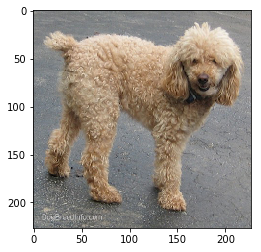

In [17]:
poodle_file = '/Users/avilay.parekh/projects/personal/deeplearning/sdc-class/CarND-Alexnet-Feature-Extraction/poodle.png'
poodle = imread(poodle_file)[:,:,:3]  # Get rid of the alpha channel
plt.imshow(poodle)

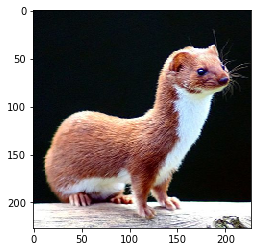

In [18]:
weasel_file = '/Users/avilay.parekh/projects/personal/deeplearning/sdc-class/CarND-Alexnet-Feature-Extraction/weasel.png'
weasel = imread(weasel_file)[:,:,:3]  # Get rid of the alpha channel
plt.imshow(weasel)

In [19]:
# Run Inference
poodle_norm = poodle - np.mean(poodle)
weasel_norm = weasel - np.mean(weasel)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    poodle_pred, weasel_pred = sess.run(probs, feed_dict={X: [poodle_norm, weasel_norm]})

In [20]:
# top five predictions for poodle image
poodle_ndxs = np.argsort(poodle_pred)
for i in [-1, -2, -3, -4, -5]:
    ndx = poodle_ndxs[i]
    name = class_names[ndx]
    prob_val = poodle_pred[ndx]
    print('[{}] {}: {:.3f}'.format(ndx, name, prob_val))

[266] miniature poodle: 0.389
[265] toy poodle: 0.223
[181] Bedlington terrier: 0.173
[267] standard poodle: 0.150
[228] komondor: 0.026


In [21]:
# top five predictions for weasel image
weasel_ndxs = np.argsort(weasel_pred)
for i in [-1, -2, -3, -4, -5]:
    ndx = weasel_ndxs[i]
    name = class_names[ndx]
    prob_val = weasel_pred[ndx]
    print('[{}] {}: {:.3f}'.format(ndx, name, prob_val))

[356] weasel: 0.331
[358] polecat, fitch, foulmart, foumart, Mustela putorius: 0.280
[359] black-footed ferret, ferret, Mustela nigripes: 0.210
[357] mink: 0.081
[279] Arctic fox, white fox, Alopex lagopus: 0.027
